In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pickle
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics import (
    roc_curve, auc, silhouette_score, calinski_harabasz_score,
    davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.saving import register_keras_serializable
from fpdf import FPDF
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [16]:
# Data configuration
base_dir = ""
data_dir = f'{base_dir}evaluation-data'  # Update this path to your data directory
img_size = (64, 64)
num_channels = 3
file_ext = ".jpeg"

# Model paths - Update these paths to your actual model files
MODEL_PATHS = {
    'CAE': f'{base_dir}models/cae_model_final.h5',
    # 'AAE': 'aae_model_final.h5'
    'VAE': f'{base_dir}models/vae_model_final.h5'
}

# True labels for evaluation (update based on your actual data structure)
# Assuming 10 images per person, 5 people
TRUE_LABELS = np.repeat(np.arange(5), 10)  # [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,...]
PERSON_NAMES = ['Alexis Putellas', 'Karim Benzema', 'Emma Watson', 'Jack Grealish', 'Erling Haaland']

def load_data(data_dir):
    """
    Load and preprocess images from directory

    Returns:
        np.array: Normalized images array of shape (n_samples, height, width, channels)
    """
    file_names = [f for f in os.listdir(data_dir) if f.endswith(file_ext)]
    file_names.sort()

    images = np.zeros((len(file_names), img_size[0], img_size[1], num_channels), dtype=np.float32)

    for i, file_name in enumerate(file_names):
        img = Image.open(os.path.join(data_dir, file_name))
        img = img.resize(img_size)
        img = np.array(img, dtype=np.float32) / 255.0
        images[i] = img

    print(f"Loaded {len(images)} images of shape {images.shape[1:]}")
    return images

# Load data
print("Loading data...")
x_manual = load_data(data_dir)

Loading data...
Loaded 50 images of shape (64, 64, 3)


In [17]:
@register_keras_serializable()
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAELossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        encoder_inputs, outputs, z_mean, z_log_var = inputs

        reconstruction_loss = tf.reduce_sum(tf.square(encoder_inputs - outputs), axis=[1, 2, 3])
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

        self.add_loss(total_loss)
        return outputs

def load_models():
    """
    Load all available models

    Returns:
        dict: Dictionary of loaded models
    """
    models = {}

    for model_name, model_path in MODEL_PATHS.items():
        if os.path.exists(model_path):
            try:
                if model_name == 'VAE':
                    # For VAE, we need the encoder part
                    vae_model = load_model(model_path, compile=False, custom_objects={'VAELossLayer': VAELossLayer})
                    models[model_name] = vae_model
                else:
                    models[model_name] = load_model(model_path, compile=False)
                print(f"✓ Loaded {model_name} model from {model_path}")
            except Exception as e:
                print(f"✗ Failed to load {model_name} model: {e}")
        else:
            print(f"⚠ {model_name} model not found at {model_path}")

    return models

def extract_embeddings(models, data):
    """
    Extract embeddings from all models

    Args:
        models (dict): Dictionary of loaded models
        data (np.array): Input images

    Returns:
        dict: Dictionary of embeddings for each model
    """
    embeddings = {}

    for model_name, model in models.items():
        try:
            if model_name == 'VAE':
                # For VAE, extract latent space embeddings (z_mean)
                encoder_output = model.predict(data, verbose=0)
                if isinstance(encoder_output, list) and len(encoder_output) >= 3:
                    # Assuming VAE returns [reconstruction, z_mean, z_log_var]
                    embeddings[model_name] = encoder_output[1]  # z_mean
                else:
                    # If VAE returns different format
                    embeddings[model_name] = encoder_output
            else:
                # For CAE and AAE, extract encoder output
                # You might need to adjust this based on your model architecture
                embeddings[model_name] = model.predict(data, verbose=0)

            print(f"✓ Extracted {model_name} embeddings: {embeddings[model_name].shape}")
        except Exception as e:
            print(f"✗ Failed to extract {model_name} embeddings: {e}")

    return embeddings

# Load models and extract embeddings
print("\nLoading models...")
models = load_models()

print("\nExtracting embeddings...")
embeddings = extract_embeddings(models, x_manual)


Loading models...
✓ Loaded CAE model from models/cae_model_final.h5
✓ Loaded VAE model from models/vae_model_final.h5

Extracting embeddings...
✓ Extracted CAE embeddings: (50, 64, 64, 3)
✓ Extracted VAE embeddings: (50, 64, 64, 3)


In [18]:
class ModelEvaluator:
    """
    Comprehensive model evaluation class
    """

    def __init__(self, embeddings, true_labels, person_names):
        self.embeddings = embeddings
        self.true_labels = true_labels
        self.person_names = person_names
        self.results = {}

    def compute_similarity_metrics(self):
        """
        Compute various similarity metrics between embeddings
        """
        print("\n" + "="*50)
        print("SIMILARITY METRICS ANALYSIS")
        print("="*50)

        similarity_results = {}

        for model_name, emb in self.embeddings.items():
            # Flatten embeddings if needed
            if len(emb.shape) > 2:
                emb = emb.reshape(emb.shape[0], -1)

            # Compute pairwise similarities
            cosine_sim = cosine_similarity(emb)
            euclidean_dist = euclidean_distances(emb)

            # Intra-class vs Inter-class similarities
            intra_class_sims = []
            inter_class_sims = []

            for i in range(len(self.true_labels)):
                for j in range(i+1, len(self.true_labels)):
                    sim = cosine_sim[i, j]
                    if self.true_labels[i] == self.true_labels[j]:
                        intra_class_sims.append(sim)
                    else:
                        inter_class_sims.append(sim)

            # Compute statistics
            intra_mean = np.mean(intra_class_sims)
            inter_mean = np.mean(inter_class_sims)
            separation_score = intra_mean - inter_mean  # Higher is better

            similarity_results[model_name] = {
                'intra_class_similarity': intra_mean,
                'inter_class_similarity': inter_mean,
                'separation_score': separation_score,
                'cosine_similarity_matrix': cosine_sim,
                'euclidean_distance_matrix': euclidean_dist
            }

            print(f"\n{model_name} Model:")
            print(f"  Intra-class similarity: {intra_mean:.4f}")
            print(f"  Inter-class similarity: {inter_mean:.4f}")
            print(f"  Separation score: {separation_score:.4f}")

        return similarity_results

    def compute_clustering_metrics(self, n_clusters=5):
        """
        Evaluate clustering performance using multiple algorithms
        """
        print("\n" + "="*50)
        print("CLUSTERING PERFORMANCE ANALYSIS")
        print("="*50)

        clustering_results = {}

        # Clustering algorithms to evaluate
        clustering_algorithms = {
            'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
            'SpectralClustering': SpectralClustering(n_clusters=n_clusters, random_state=42),
            'GMM': GaussianMixture(n_components=n_clusters, random_state=42),
            'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters)
        }

        for model_name, emb in self.embeddings.items():
            # Flatten embeddings if needed
            if len(emb.shape) > 2:
                emb = emb.reshape(emb.shape[0], -1)

            # Standardize embeddings
            scaler = StandardScaler()
            emb_scaled = scaler.fit_transform(emb)

            model_clustering_results = {}

            for alg_name, algorithm in clustering_algorithms.items():
                try:
                    if alg_name == 'GMM':
                        predicted_labels = algorithm.fit_predict(emb_scaled)
                    else:
                        predicted_labels = algorithm.fit_predict(emb_scaled)

                    # Compute clustering metrics
                    silhouette = silhouette_score(emb_scaled, predicted_labels)
                    calinski_harabasz = calinski_harabasz_score(emb_scaled, predicted_labels)
                    davies_bouldin = davies_bouldin_score(emb_scaled, predicted_labels)

                    # Compute external metrics (if true labels available)
                    if self.true_labels is not None:
                        ari = adjusted_rand_score(self.true_labels, predicted_labels)
                        nmi = normalized_mutual_info_score(self.true_labels, predicted_labels)
                    else:
                        ari = nmi = None

                    model_clustering_results[alg_name] = {
                        'predicted_labels': predicted_labels,
                        'silhouette_score': silhouette,
                        'calinski_harabasz_score': calinski_harabasz,
                        'davies_bouldin_score': davies_bouldin,
                        'adjusted_rand_score': ari,
                        'normalized_mutual_info': nmi
                    }

                except Exception as e:
                    print(f"  Failed to run {alg_name} on {model_name}: {e}")
                    continue

            clustering_results[model_name] = model_clustering_results

            # Print results
            print(f"\n{model_name} Model Clustering Results:")
            for alg_name, metrics in model_clustering_results.items():
                print(f"  {alg_name}:")
                print(f"    Silhouette Score: {metrics['silhouette_score']:.4f}")
                print(f"    Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.2f}")
                print(f"    Davies-Bouldin Score: {metrics['davies_bouldin_score']:.4f}")
                if metrics['adjusted_rand_score'] is not None:
                    print(f"    Adjusted Rand Index: {metrics['adjusted_rand_score']:.4f}")
                    print(f"    Normalized Mutual Info: {metrics['normalized_mutual_info']:.4f}")

        return clustering_results

    def compute_reconstruction_quality(self, models, original_images):
        """
        Evaluate reconstruction quality for autoencoders
        """
        print("\n" + "="*50)
        print("RECONSTRUCTION QUALITY ANALYSIS")
        print("="*50)

        reconstruction_results = {}

        for model_name, model in models.items():
            try:
                # Get reconstructions
                reconstructions = model.predict(original_images, verbose=0)

                # Compute metrics
                mse = np.mean((original_images - reconstructions) ** 2)
                psnr = 20 * np.log10(1.0 / np.sqrt(mse))

                # Structural similarity (simplified)
                ssim_scores = []
                for i in range(len(original_images)):
                    orig = original_images[i]
                    recon = reconstructions[i]

                    # Simple correlation-based similarity
                    correlation = np.corrcoef(orig.flatten(), recon.flatten())[0, 1]
                    ssim_scores.append(correlation)

                avg_ssim = np.mean(ssim_scores)

                reconstruction_results[model_name] = {
                    'reconstructions': reconstructions,
                    'mse': mse,
                    'psnr': psnr,
                    'avg_ssim': avg_ssim
                }

                print(f"\n{model_name} Model:")
                print(f"  MSE: {mse:.6f}")
                print(f"  PSNR: {psnr:.2f} dB")
                print(f"  Average SSIM: {avg_ssim:.4f}")

            except Exception as e:
                print(f"  Failed to evaluate reconstruction for {model_name}: {e}")

        return reconstruction_results

    def generate_comprehensive_report(self):
        """
        Generate a comprehensive evaluation report
        """
        print("\n" + "="*60)
        print("COMPREHENSIVE MODEL EVALUATION REPORT")
        print("="*60)

        # Run all evaluations
        similarity_results = self.compute_similarity_metrics()
        clustering_results = self.compute_clustering_metrics()

        # Store results
        self.results = {
            'similarity': similarity_results,
            'clustering': clustering_results
        }

        # Summary comparison
        print("\n" + "="*50)
        print("SUMMARY COMPARISON")
        print("="*50)

        # Create comparison table
        comparison_data = []
        for model_name in self.embeddings.keys():
            if model_name in similarity_results and model_name in clustering_results:
                row = {
                    'Model': model_name,
                    'Separation Score': similarity_results[model_name]['separation_score'],
                    'Best Silhouette': max([metrics['silhouette_score']
                                          for metrics in clustering_results[model_name].values()]),
                    'Best ARI': max([metrics['adjusted_rand_score']
                                   for metrics in clustering_results[model_name].values()
                                   if metrics['adjusted_rand_score'] is not None] or [0])
                }
                comparison_data.append(row)

        # Print comparison
        print("\nModel Performance Summary:")
        print("-" * 60)
        print(f"{'Model':<15} {'Separation':<12} {'Best Silhouette':<15} {'Best ARI':<10}")
        print("-" * 60)
        for row in comparison_data:
            print(f"{row['Model']:<15} {row['Separation Score']:<12.4f} {row['Best Silhouette']:<15.4f} {row['Best ARI']:<10.4f}")

        return self.results

In [19]:
def plot_embeddings_tsne(embeddings, true_labels, person_names):
    """
    Visualize embeddings using t-SNE
    """
    print("\nGenerating t-SNE visualizations...")

    n_models = len(embeddings)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]

    colors = plt.cm.Set3(np.linspace(0, 1, len(person_names)))

    for idx, (model_name, emb) in enumerate(embeddings.items()):
        # Flatten embeddings if needed
        if len(emb.shape) > 2:
            emb = emb.reshape(emb.shape[0], -1)

        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(emb)-1))
        emb_2d = tsne.fit_transform(emb)

        # Plot
        ax = axes[idx]
        for i, person in enumerate(person_names):
            mask = true_labels == i
            ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1],
                      c=[colors[i]], label=person, alpha=0.7, s=50)

        ax.set_title(f'{model_name} Embeddings (t-SNE)', fontsize=14)
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_similarity_matrices(similarity_results):
    """
    Plot similarity matrices for all models
    """
    print("\nGenerating similarity matrices...")

    n_models = len(similarity_results)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]

    for idx, (model_name, results) in enumerate(similarity_results.items()):
        ax = axes[idx]
        im = ax.imshow(results['cosine_similarity_matrix'], cmap='viridis', aspect='auto')
        ax.set_title(f'{model_name} Cosine Similarity Matrix')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Sample Index')
        plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

def plot_reconstructions(reconstruction_results, original_images, n_samples=5):
    """
    Plot original vs reconstructed images
    """
    print("\nGenerating reconstruction comparisons...")

    n_models = len(reconstruction_results)
    fig, axes = plt.subplots(n_models, 2*n_samples, figsize=(2*n_samples*2, n_models*2))

    if n_models == 1:
        axes = axes.reshape(1, -1)

    for model_idx, (model_name, results) in enumerate(reconstruction_results.items()):
        reconstructions = results['reconstructions']

        for i in range(n_samples):
            # Original image
            ax_orig = axes[model_idx, 2*i]
            ax_orig.imshow(original_images[i])
            ax_orig.set_title(f'Original {i+1}' if model_idx == 0 else '')
            ax_orig.axis('off')

            # Reconstructed image
            ax_recon = axes[model_idx, 2*i + 1]
            ax_recon.imshow(reconstructions[i])
            ax_recon.set_title(f'Reconstructed {i+1}' if model_idx == 0 else '')
            ax_recon.axis('off')

        # Add model name on the left
        axes[model_idx, 0].text(-0.1, 0.5, model_name, transform=axes[model_idx, 0].transAxes,
                               rotation=90, va='center', ha='right', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_clustering_performance(clustering_results):
    """
    Plot clustering performance metrics
    """
    print("\nGenerating clustering performance plots...")

    metrics = ['silhouette_score', 'adjusted_rand_score', 'normalized_mutual_info']
    metric_names = ['Silhouette Score', 'Adjusted Rand Index', 'Normalized Mutual Info']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for metric_idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        ax = axes[metric_idx]

        model_names = list(clustering_results.keys())
        algorithm_names = list(clustering_results[model_names[0]].keys())

        x = np.arange(len(algorithm_names))
        width = 0.25

        for i, model_name in enumerate(model_names):
            values = []
            for alg_name in algorithm_names:
                value = clustering_results[model_name][alg_name][metric]
                values.append(value if value is not None else 0)

            ax.bar(x + i*width, values, width, label=model_name, alpha=0.8)

        ax.set_xlabel('Clustering Algorithm')
        ax.set_ylabel(metric_name)
        ax.set_title(f'{metric_name} by Model and Algorithm')
        ax.set_xticks(x + width)
        ax.set_xticklabels(algorithm_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [20]:
def main_evaluation():
    """
    Run comprehensive evaluation
    """
    print("="*60)
    print("STARTING COMPREHENSIVE MODEL EVALUATION")
    print("="*60)

    if not embeddings:
        print("No embeddings available for evaluation!")
        return

    # Initialize evaluator
    evaluator = ModelEvaluator(embeddings, TRUE_LABELS, PERSON_NAMES)

    # Run comprehensive evaluation
    results = evaluator.generate_comprehensive_report()

    # Generate visualizations
    print("\n" + "="*50)
    print("GENERATING VISUALIZATIONS")
    print("="*50)

    # t-SNE visualization
    plot_embeddings_tsne(embeddings, TRUE_LABELS, PERSON_NAMES)

    # Similarity matrices
    if 'similarity' in results:
        plot_similarity_matrices(results['similarity'])

    # Clustering performance
    if 'clustering' in results:
        plot_clustering_performance(results['clustering'])

    # Reconstruction quality (if models available)
    if models:
        reconstruction_results = evaluator.compute_reconstruction_quality(models, x_manual[:10])
        if reconstruction_results:
            plot_reconstructions(reconstruction_results, x_manual[:10])

    print("\n" + "="*60)
    print("EVALUATION COMPLETE!")
    print("="*60)

    return results

STARTING COMPREHENSIVE MODEL EVALUATION

COMPREHENSIVE MODEL EVALUATION REPORT

SIMILARITY METRICS ANALYSIS

CAE Model:
  Intra-class similarity: 0.9452
  Inter-class similarity: 0.9231
  Separation score: 0.0221

VAE Model:
  Intra-class similarity: 0.9337
  Inter-class similarity: 0.9052
  Separation score: 0.0284

CLUSTERING PERFORMANCE ANALYSIS
  Failed to run GMM on CAE: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, increase reg_covar, or scale the input data. The numerical accuracy can also be improved by passing float64 data instead of float32.

CAE Model Clustering Results:
  KMeans:
    Silhouette Score: 0.1180
    Calinski-Harabasz Score: 7.46
    Davies-Bouldin Score: 2.0419
    Adjusted Rand Index: 0.3064
    Normalized Mutual Info: 0.4370
  SpectralClustering:
    Silhouette Score: -0.0479
    Calinski-Harabasz Score: 1.13
    

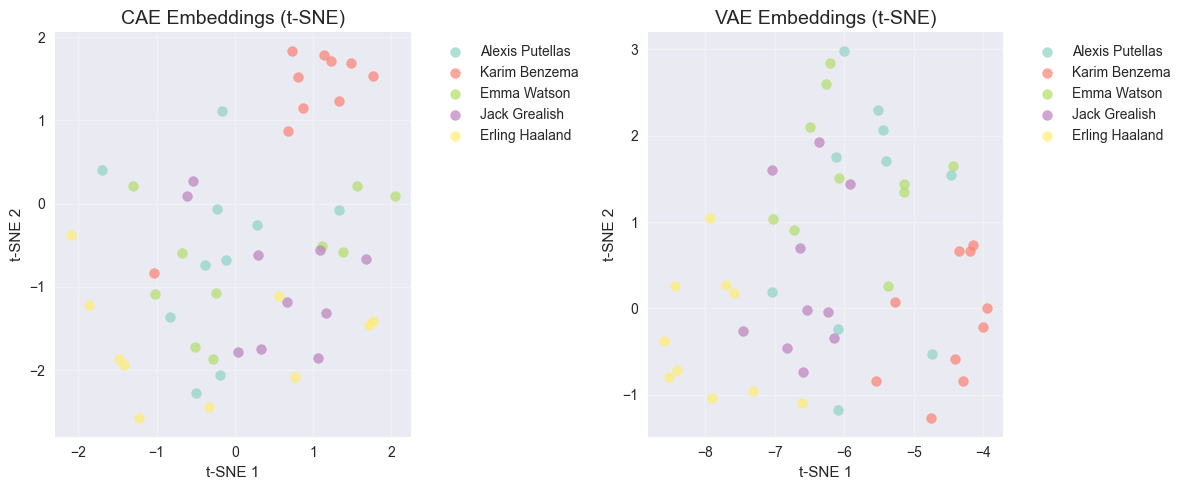


Generating similarity matrices...


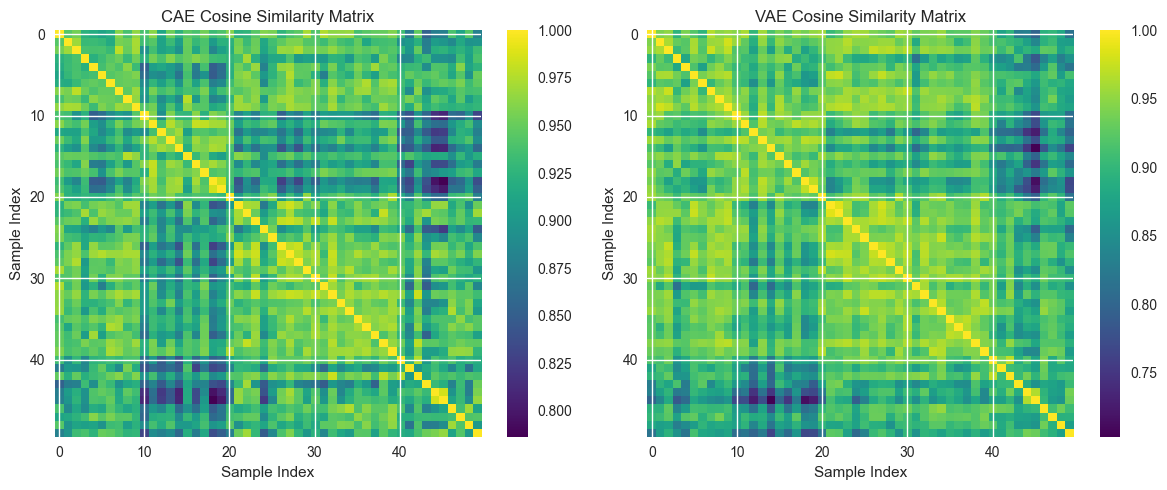


Generating clustering performance plots...


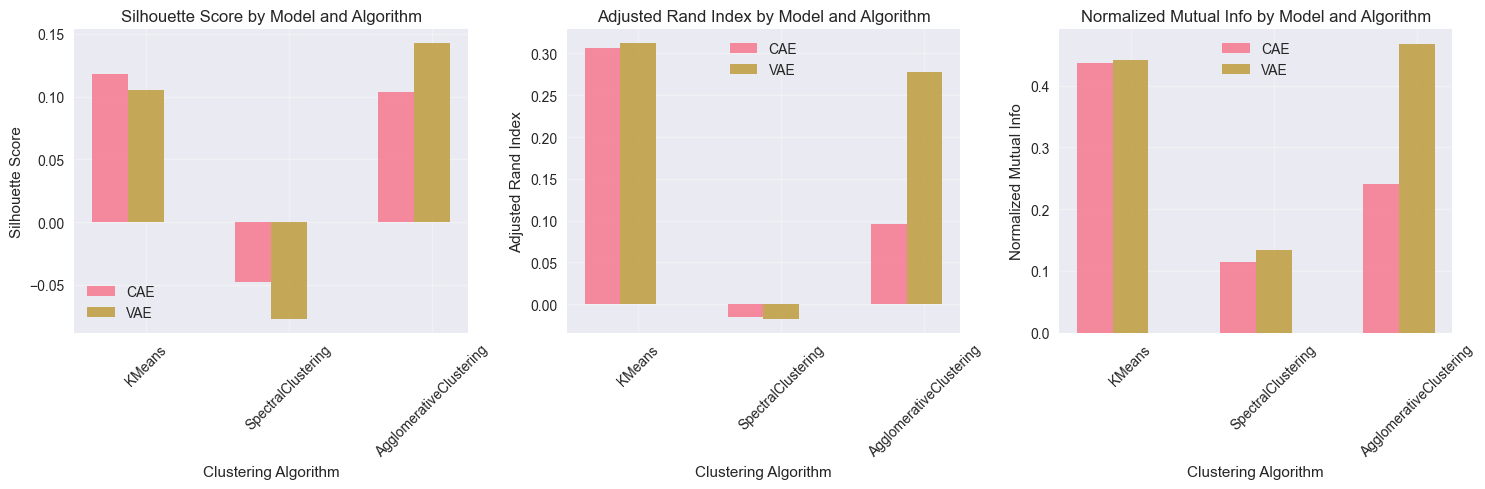


RECONSTRUCTION QUALITY ANALYSIS

CAE Model:
  MSE: 0.064374
  PSNR: 11.91 dB
  Average SSIM: 0.3786

VAE Model:
  MSE: 0.013920
  PSNR: 18.56 dB
  Average SSIM: 0.8087

Generating reconstruction comparisons...


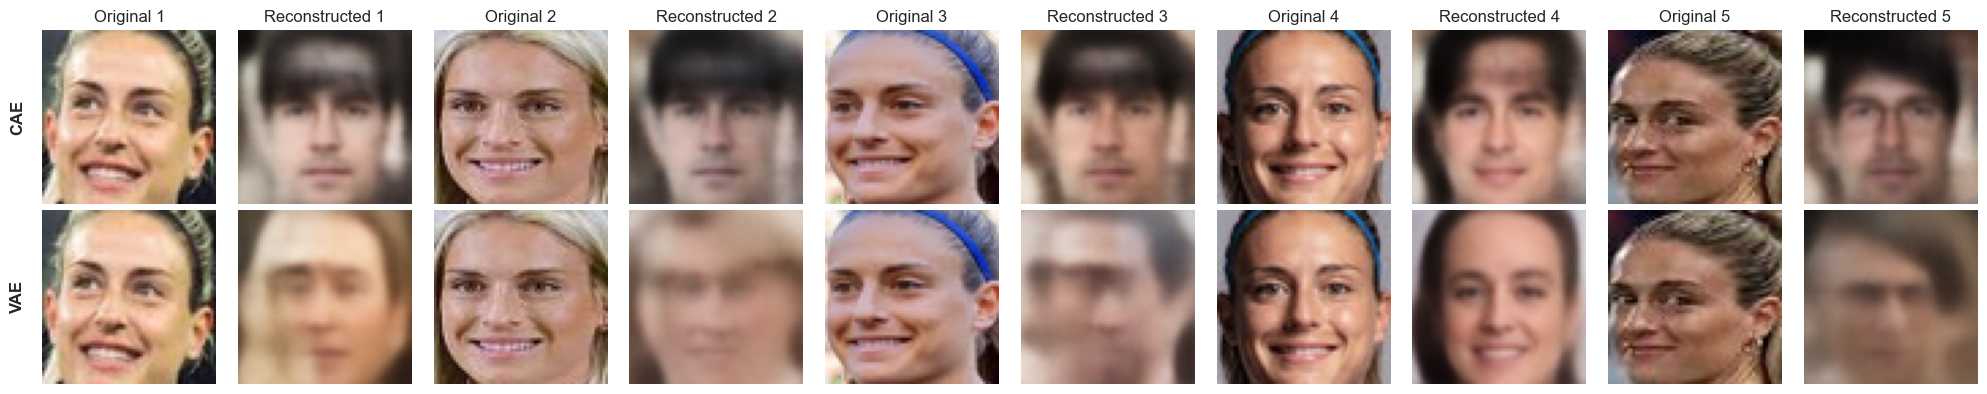


EVALUATION COMPLETE!

Evaluation results saved to evaluation_results.pdf

Evaluation results saved to evaluation_results.pkl


In [21]:
def save_results_to_pdf(results, filename="evaluation_results.pdf"):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.set_font("Arial", size=12)

    # If results is a dict or list, convert to string line-by-line
    if isinstance(results, (dict, list)):
        lines = str(results).splitlines()
    else:
        lines = str(results).split('\n')

    for line in lines:
        pdf.multi_cell(0, 10, txt=line)

    pdf.output(filename)
    print(f"\nEvaluation results saved to {filename}")

# Example usage
evaluation_results = main_evaluation()
save_results_to_pdf(evaluation_results)

print("\nEvaluation results saved to evaluation_results.pkl")